# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

We need to figure out which plan will bring in more revenue for Megaline after we have analyzed the clients; behavior.

## Initialization

Loading the required libraries.

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
from datetime import datetime
import re

## Load data

Importing the data.

In [2]:
# Load the data files into different DataFrames
# calls = pd.read_csv('megaline_calls.csv')
# internet = pd.read_csv('megaline_internet.csv')
# messages = pd.read_csv('megaline_messages.csv')
# plans = pd.read_csv('megaline_plans.csv')
# users = pd.read_csv('megaline_users.csv')

#fix by reviewer

calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Prepare the data

From the general information about the calls dataframe, we can see that there is no null values in the dataframe. We proceed to convert datatypes in the calls dataframe. By inspecting the calls data, we identified another problem with the data. Some data in the duration column has values greater than 0 but less than 1 minutes. For such values, we would be rounding up duration less than 1 minutes to 1 minutes.

In [3]:
# apply numpy vectorizing to id
get_id = np.vectorize(lambda x: re.sub('.*_', '' ,  x))

In [4]:
# change date type to datetime and split into day, month and year
def new_date_features(df):
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns if 'date' in x][0]
    
    df[columns[idx]] = pd.to_datetime(df[columns[idx]])
    df['day'] = df[columns[idx]].dt.day_name()
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year
    return df    

## Plans

In [5]:
# Print the general/summary information about the plans' DataFrame
plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [6]:
# Print a sample of data for plans
plans.head(2)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


I dont see any issues with the data off my inital look, The amount of texts included is equal to the project discription. Same with minutes_included, monthly charge looks right,The per_gb, message, and minute values look correct. It looks like the mb per month included is off on both it should be 15000, and 30000, not 15360 and 30720. I will fix that in the next cell.

## Enrich data

In [7]:
# rename `plans` columns
plans.columns = ['messages included', 'data volume per month', 'minutes included', 'monthly fee', 'price per gb', 'price per message', 'price per minute', 'plan']
plans.head()

,messages included,data volume per month,minutes included,monthly fee,price per gb,price per message,price per minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Users

In [8]:
# Print the general/summary information about the users' DataFrame
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Print a sample of data for users
users.head(5)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Some intial takeaways from the data. Churn data is NaN. Unsure what other values are there. Will check in next cell. reg_date should be in datetime form.

### Fix Data

We look at the user dataframe by checking for null values and change datatype in this dataframe. Another error we noticed is in the churn_date column where 466 values is missing. This large portion of missing values in the churn_date field will be transformed into either churn ='Yes' or no churn = 'No', thus it can be analyzed as a categorical variable.

In [10]:
#Okay so Im assuming NaN means that they are still apart of Megaline and haven't dismissed their service.
users['churn_date'].unique()

array([nan, '2018-12-18', '2018-11-16', '2018-09-07', '2018-12-30',
       '2018-10-07', '2018-12-31', '2018-11-24', '2018-11-11',
       '2018-12-12', '2018-11-14', '2018-12-27', '2018-11-29',
       '2018-12-22', '2018-11-30', '2018-10-13', '2018-07-31',
       '2018-12-15', '2018-12-19', '2018-10-03', '2018-10-22',
       '2018-08-16', '2018-12-26', '2018-09-01', '2018-11-21',
       '2018-08-19', '2018-12-10', '2018-09-17', '2018-11-18',
       '2018-09-18'], dtype=object)

In [11]:
# change the `reg_date` in the `users` to datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')

# change the `churn date` to datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
users.columns = ['user', 'first name', 'last name', 'age', 'city', 'subscription date', 'plan', 'churn date']

# create categorical variable for whether customer churn or not
users['customer churn'] = np.where(users['churn date'].isnull(), 'No', 'Yes')
users.head() 

,user,first name,last name,age,city,subscription date,plan,churn date,customer churn
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,No
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,No
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,No
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,No


### Enrich Data

No additional features are required for Users data table.

## Calls

In [12]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Print a sample of data for calls
calls.head(5)


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


I dont see too many issues. convert call_date to datetime, change the column name for id to call_id, I think that duration might be in the wrong data type. Maybe it should be some kind of time datatype. But I will leave it as is until I need it in that form later on.

A revision after making it to aggregate data per user* I think instead of converting the dates to datetime it will be easier to just leave it as it is in terms of its type. I will instead drop the day part of call_date as we are analyzing people by monthly use. 

### Fix data

In [14]:
# change the `calls_date` to datetime datatype
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
calls['id'] = get_id(calls['id'])
calls = new_date_features(calls)
calls['call type'] = np.where(calls['duration'] == 0, 'Missed call', 'Connected call')
calls.head()

,id,user_id,call_date,duration,day,month,year,call type
0,93,1000,2018-12-27,8.52,Thursday,December,2018,Connected call
1,145,1000,2018-12-27,13.66,Thursday,December,2018,Connected call
2,247,1000,2018-12-27,14.48,Thursday,December,2018,Connected call
3,309,1000,2018-12-28,5.76,Friday,December,2018,Connected call
4,380,1000,2018-12-30,4.22,Sunday,December,2018,Connected call


### Enrich data

No additional features are required for Calls data table.

In [15]:
calls['duration'] = np.ceil(calls['duration'])
calls.head(10)

,id,user_id,call_date,duration,day,month,year,call type
0,93,1000,2018-12-27,9.0,Thursday,December,2018,Connected call
1,145,1000,2018-12-27,14.0,Thursday,December,2018,Connected call
2,247,1000,2018-12-27,15.0,Thursday,December,2018,Connected call
3,309,1000,2018-12-28,6.0,Friday,December,2018,Connected call
4,380,1000,2018-12-30,5.0,Sunday,December,2018,Connected call
5,388,1000,2018-12-31,3.0,Monday,December,2018,Connected call
6,510,1000,2018-12-27,6.0,Thursday,December,2018,Connected call
7,521,1000,2018-12-28,15.0,Friday,December,2018,Connected call
8,530,1000,2018-12-28,6.0,Friday,December,2018,Connected call
9,544,1000,2018-12-26,5.0,Wednesday,December,2018,Connected call


## Messages

In [16]:
# Print the general/summary information about the messages' DataFrame
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [17]:
# Print a sample of data for messages
messages.head(5)


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


 message_date should be in datetime form. Nothing else looks weird. 

### Fix data

We look at the messages, internet and plans. We need to change datatype to datetime, and rename the columns.

In [18]:
# change the `message_date` in the `messages` to datetime
#messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
messages['id'] = get_id(messages['id'])
messages = new_date_features(messages)
messages.columns = ['id', 'user', 'message date', 'day', 'month', 'year']
messages.head()

,id,user,message date,day,month,year
0,125,1000,2018-12-27,Thursday,December,2018
1,160,1000,2018-12-31,Monday,December,2018
2,223,1000,2018-12-31,Monday,December,2018
3,251,1000,2018-12-27,Thursday,December,2018
4,255,1000,2018-12-26,Wednesday,December,2018


## Internet

In [19]:
# Print the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Print a sample of data for the internet traffic
internet.head(5)


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Convert session_date to datetime. mb_used has a weird value of zero. ill check if thats a common problem. I think removing those rows with 0 mb_used could prove useful.

### Fix data

In [21]:
# change the `session_date` in `internet` to datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
internet['id'] = get_id(internet['id'])
internet = new_date_features(internet)
internet.columns = ['id', 'user', 'session date', 'data used', 'day', 'month', 'year'] # rename columns
internet.head()

,id,user,session date,data used,day,month,year
0,13,1000,2018-12-29,89.86,Saturday,December,2018
1,204,1000,2018-12-31,0.00,Monday,December,2018
2,379,1000,2018-12-28,660.40,Friday,December,2018
3,413,1000,2018-12-26,270.99,Wednesday,December,2018
4,442,1000,2018-12-27,880.22,Thursday,December,2018


We identified the problem with the datatype in earlier section. In this section, we fixed some of the problems identifies. One of the problems identified in the dataset is that the subscription date, churn date in the users dataframe, call date in the calls dataframe, message date in the messages dataframe, and session date in the internet dataframe are of datatype object. We converted this datatype to datetime datatype. We also rounded up each individual calls. In addition, we created a new column in the users dataframe to show whether a customer churn or not.

## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

Print out the plan conditions and make sure they are clear for you:
SURF: Monthly Charge $20, 500 Monthly Minutes, 50 Texts, 15 GB
    Exceeding - 1 minute: 3 cents, 1 text message: 3 cents, 1GB: $10
ULTIMATE: Monthlu Charge $70, 3000 Monthly Minutes, 1000 Texts, 30 GB
    Exceeding - 1 minute: 1 cent, 1 text message: 1 cent, 1 GB: $7

## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [22]:
# check if all users are accounted for in other tables
print(calls['user_id'].nunique())
print(users['user'].nunique())
print(messages['user'].nunique())
print(internet['user'].nunique())

481
500
402
489


In [23]:
# function to display tables side by side for analysis
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle([''])) ):
        html_str+=''
        html_str+=f'{title}'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+=''
    display_html(html_str,raw=True)

In [24]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_month = calls.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns={'id': 'calls made'})#.reset_index()
display_side_by_side(calls_per_month.head(), calls_per_month.describe(), titles=[
    'Head of calls per month', 'Describe calls per month'])

Head of calls per month 
 
 
 
 
 calls made 
 
 
 user_id 
 month 
 
 
 
 
 
 1000 
 December 
 16 
 
 
 1001 
 August 
 27 
 
 
 December 
 56 
 
 
 November 
 64 
 
 
 October 
 65 
 
 
 Describe calls per month 
 
 
 
 calls made 
 
 
 
 
 count 
 2258.000000 
 
 
 mean 
 60.998671 
 
 
 std 
 31.770869 
 
 
 min 
 1.000000 
 
 
 25% 
 39.000000 
 
 
 50% 
 60.000000 
 
 
 75% 
 80.000000 
 
 
 max 
 205.000000

In [25]:
# Calculate the amount of minutes spent by each user per month. Save the result.
mins_per_month = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).rename(columns={'duration': 'minutes spent'})
display_side_by_side(mins_per_month.head(), mins_per_month.describe(), titles=[
    'Head of minutes per month', 'Describe minutes per month'])


Head of minutes per month 
 
 
 
 
 minutes spent 
 
 
 user_id 
 month 
 
 
 
 
 
 1000 
 December 
 124.0 
 
 
 1001 
 August 
 182.0 
 
 
 December 
 412.0 
 
 
 November 
 426.0 
 
 
 October 
 393.0 
 
 
 Describe minutes per month 
 
 
 
 minutes spent 
 
 
 
 
 count 
 2258.000000 
 
 
 mean 
 435.937555 
 
 
 std 
 231.972343 
 
 
 min 
 0.000000 
 
 
 25% 
 275.000000 
 
 
 50% 
 429.000000 
 
 
 75% 
 574.750000 
 
 
 max 
 1510.000000

From the number of calls made per month, we can see that about 1499 users made calls out of 2258 users. The person with the highest call rate made 205 calls and spent a total minute of 1510 minutes, while the person with the lowest call rate made just 1 calls with 0 minutes which could have even been a missed call. Since the mean of minutes spent is greater than the median, we expect the distribution to be skewed to the right. This means the data could contain outliers.

In [26]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_month = messages.groupby(['user', 'month']).agg({'id': 'count'}).rename(columns={'id': 'messages sent'})
display_side_by_side(messages_per_month.head(), messages_per_month.describe(), titles=[
    'Head of messages per month', 'Describe messages per month'])


Head of messages per month 
 
 
 
 
 messages sent 
 
 
 user 
 month 
 
 
 
 
 
 1000 
 December 
 11 
 
 
 1001 
 August 
 30 
 
 
 December 
 44 
 
 
 November 
 36 
 
 
 October 
 53 
 
 
 Describe messages per month 
 
 
 
 messages sent 
 
 
 
 
 count 
 1806.000000 
 
 
 mean 
 42.110188 
 
 
 std 
 33.122931 
 
 
 min 
 1.000000 
 
 
 25% 
 17.000000 
 
 
 50% 
 34.000000 
 
 
 75% 
 59.000000 
 
 
 max 
 266.000000

In [27]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_per_month = (internet.groupby(['user', 'month']).agg({'data used': 'sum'})/1024).apply(np.ceil)*1024
display_side_by_side(internet_per_month.head(), internet_per_month.describe(), titles=[
    'Head of data used per month', 'Describe data used per month'])


Head of data used per month 
 
 
 
 
 data used 
 
 
 user 
 month 
 
 
 
 
 
 1000 
 December 
 2048.0 
 
 
 1001 
 August 
 7168.0 
 
 
 December 
 19456.0 
 
 
 November 
 19456.0 
 
 
 October 
 22528.0 
 
 
 Describe data used per month 
 
 
 
 data used 
 
 
 
 
 count 
 2277.000000 
 
 
 mean 
 17396.757137 
 
 
 std 
 7878.331628 
 
 
 min 
 1024.000000 
 
 
 25% 
 13312.000000 
 
 
 50% 
 17408.000000 
 
 
 75% 
 21504.000000 
 
 
 max 
 71680.000000

In [28]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
agg_df = pd.concat([calls_per_month, mins_per_month, messages_per_month, internet_per_month], axis=1).reset_index().fillna(0)
agg_df.columns = ['user', 'month', 'calls made', 'call duration', 'messages sent', 'mb used']
agg_df = agg_df.merge(users, on='user')
agg_df


,user,month,calls made,call duration,messages sent,mb used,first name,last name,age,city,subscription date,plan,churn date,customer churn
0,1000,December,16.0,124.0,11.0,2048.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,No
1,1001,August,27.0,182.0,30.0,7168.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
2,1001,December,56.0,412.0,44.0,19456.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
3,1001,November,64.0,426.0,36.0,19456.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
4,1001,October,65.0,393.0,53.0,22528.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,September,45.0,363.0,0.0,23552.0,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT,No
2289,1499,December,65.0,496.0,0.0,22528.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaT,No
2290,1499,November,45.0,308.0,0.0,17408.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaT,No
2291,1499,October,53.0,385.0,0.0,20480.0,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaT,No


In [29]:
# Add the plan information
agg_df = agg_df.merge(plans, left_on='plan', right_on='plan')
agg_df.head()


,user,month,calls made,call duration,messages sent,mb used,first name,last name,age,city,...,plan,churn date,customer churn,messages included,data volume per month,minutes included,monthly fee,price per gb,price per message,price per minute
0,1000,December,16.0,124.0,11.0,2048.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,ultimate,NaT,No,1000,30720,3000,70,7,0.01,0.01
1,1006,December,9.0,59.0,139.0,32768.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,ultimate,2018-12-18,Yes,1000,30720,3000,70,7,0.01,0.01
2,1006,November,2.0,10.0,15.0,3072.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,ultimate,2018-12-18,Yes,1000,30720,3000,70,7,0.01,0.01
3,1008,December,85.0,634.0,26.0,15360.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,ultimate,NaT,No,1000,30720,3000,70,7,0.01,0.01
4,1008,November,63.0,446.0,37.0,24576.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,ultimate,NaT,No,1000,30720,3000,70,7,0.01,0.01


In [30]:
# Calculate the monthly revenue for each user
agg_df['message cost'] = agg_df.apply(lambda x: max(0, x['messages sent'] - x['messages included']) * x['price per message'], 
                                      axis = 1)
agg_df['call cost'] = agg_df.apply(lambda x: max(0, x['call duration'] - x['minutes included']) * x['price per minute'], 
                                   axis = 1)
agg_df['gb cost'] = agg_df.apply(lambda x: np.ceil(max(0, x['mb used'] - x['data volume per month'])/1024)*x['price per gb'], 
                                axis = 1)
agg_df['revenue'] = agg_df['message cost'] + agg_df['call cost'] + agg_df['gb cost'] + agg_df['monthly fee']
agg_df.head()


,user,month,calls made,call duration,messages sent,mb used,first name,last name,age,city,...,data volume per month,minutes included,monthly fee,price per gb,price per message,price per minute,message cost,call cost,gb cost,revenue
0,1000,December,16.0,124.0,11.0,2048.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
1,1006,December,9.0,59.0,139.0,32768.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,14.0,84.0
2,1006,November,2.0,10.0,15.0,3072.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
3,1008,December,85.0,634.0,26.0,15360.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
4,1008,November,63.0,446.0,37.0,24576.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,30720,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0


## Study user behaviour

### Calls

In [31]:
# difference in average monthly call duration
agg_df.groupby('plan')['call duration']. describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,428.749523,234.453150,0.0,272.0,425.0,576.00,1510.0
ultimate,720.0,430.450000,240.508762,0.0,260.0,424.0,565.25,1369.0


In [32]:
from scipy import stats

In [33]:
# extract filtered data for the ultimate plan
ultimate_data = agg_df.query("plan == 'ultimate'")
ultimate_plan = ultimate_data[['calls made', 'call duration', 'messages sent', 'mb used', 'revenue']]

ultimate_plan_filtered = ultimate_plan[(np.abs(stats.zscore(ultimate_plan)) < 3).all(axis=1)]
ultimate_plan_filtered = ultimate_plan_filtered.reset_index(drop=True, inplace=False)
ultimate_plan_filtered.describe()

,calls made,call duration,messages sent,mb used,revenue
count,677.000000,677.000000,677.000000,677.000000,677.000000
mean,58.970458,418.196455,34.302806,16877.093058,70.568685
std,29.979860,216.700769,31.274291,6916.348803,3.677063
min,0.000000,0.000000,0.000000,0.000000,70.000000
25%,36.000000,260.000000,5.000000,13312.000000,70.000000
50%,60.000000,420.000000,28.000000,17408.000000,70.000000
75%,78.000000,546.000000,56.000000,20480.000000,70.000000
max,159.000000,1111.000000,139.000000,35840.000000,105.000000


In [34]:
# variance of the ultimate plan
for column in ultimate_plan_filtered:
    ultimate_plan_filtered[column].var()
    print('Variance of the ' + column + ' is {: >5.2f}'.format(ultimate_plan_filtered[column].var()))

Variance of the calls made is 898.79
Variance of the call duration is 46959.22
Variance of the messages sent is 978.08
Variance of the mb used is 47835880.77
Variance of the revenue is 13.52


In [35]:
# extract filtered data for the surf plan
surf_data = agg_df.query("plan == 'surf'")
surf_plan = surf_data[['calls made', 'call duration', 'messages sent', 'mb used', 'revenue']]

surf_plan_filtered = surf_plan[(np.abs(stats.zscore(surf_plan)) < 3).all(axis=1)]
surf_plan_filtered = surf_plan_filtered.reset_index(drop=True, inplace=False)
surf_plan_filtered.describe()

,calls made,call duration,messages sent,mb used,revenue
count,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
mean,58.357427,418.277188,28.301724,16553.761273,55.500756
std,30.313364,222.179680,28.408758,7093.722639,43.459006
min,0.000000,0.000000,0.000000,0.000000,20.000000
25%,38.000000,263.000000,2.000000,12288.000000,20.000000
50%,59.000000,416.500000,23.000000,17408.000000,40.000000
75%,78.000000,565.000000,44.000000,21504.000000,80.000000
max,155.000000,1131.000000,130.000000,35840.000000,224.230000


In [36]:

# variance for the surf plan
for column in surf_plan_filtered:
    surf_plan_filtered[column].var()
    print('Variance of ' + column + ' is: {: >5.2f}'.format(surf_plan_filtered[column].var()))

Variance of calls made is: 918.90
Variance of call duration is: 49363.81
Variance of messages sent is: 807.06
Variance of mb used is: 50320900.88
Variance of revenue is: 1888.69


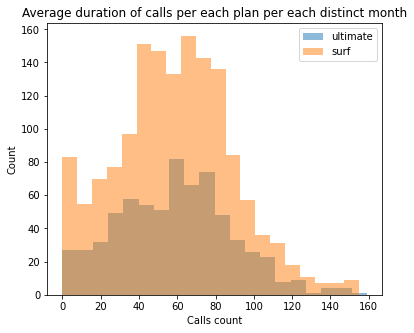

In [37]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
plt.figure(figsize=(6,5))
plt.hist(ultimate_plan_filtered['calls made'], bins=20, alpha=0.5, label='ultimate')
plt.hist(surf_plan_filtered['calls made'], bins=20, alpha=0.5, label='surf')

plt.xlabel('Calls count', size=10)
plt.ylabel('Count', size=10)
plt.title('Average duration of calls per each plan per each distinct month')
plt.legend(loc='upper right');

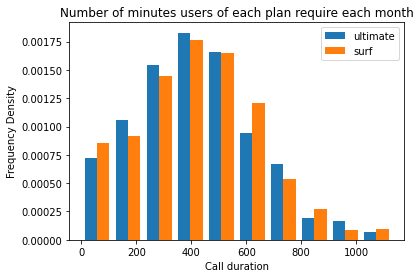

In [38]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
plt.hist([ultimate_plan_filtered['call duration'], surf_plan_filtered['call duration']], label= ['ultimate', 'surf'], density = True)
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Call duration')
plt.title('Number of minutes users of each plan require each month');


In [39]:
# Calculate the mean and the variance of the monthly call duration
agg_df.groupby('plan')['call duration'].agg([np.mean, np.var, np.std])


,mean,var,std
plan,,,
surf,428.749523,54968.279461,234.453150
ultimate,430.450000,57844.464812,240.508762


No handles with labels found to put in legend.


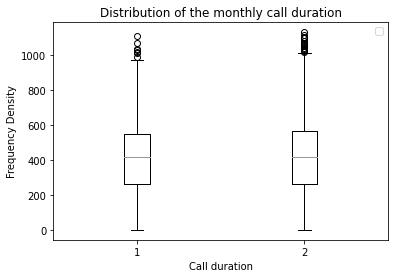

In [40]:
# Plot a boxplot to visualize the distribution of the monthly call duration
plt.boxplot([ultimate_plan_filtered['call duration'], surf_plan_filtered['call duration']])
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Call duration')
plt.title('Distribution of the monthly call duration');


### Messages

In [41]:
# Compare the number of messages users of each plan tend to send each month
# messages users of each plan send per month
agg_df.groupby('plan')['messages sent'].agg([np.mean, np.var, np.std])


,mean,var,std
plan,,,
surf,31.159568,1126.724522,33.566717
ultimate,37.551389,1208.756744,34.767179


In [42]:
# difference in average monthly messages sent
agg_df.groupby('plan')['messages sent']. describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,31.159568,33.566717,0.0,3.0,24.0,47.0,266.0
ultimate,720.0,37.551389,34.767179,0.0,7.0,30.0,61.0,166.0


In [43]:
# Compare the amount of internet traffic consumed by users per plan
# volume of data users of each plan use per month
agg_df.groupby('plan')['mb used'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,17070.789574,6.457508e+07,8035.862417
ultimate,17722.311111,6.168830e+07,7854.190127


In [44]:
# difference in average monthly mb used
agg_df.groupby('plan')['mb used']. describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,17070.789574,8035.862417,0.0,12288.0,17408.0,21504.0,71680.0
ultimate,720.0,17722.311111,7854.190127,0.0,13312.0,17408.0,21504.0,47104.0


On the average, about 1806 messages was sent per user per month. The least number of message sent was 1 while the most message sent was 266. Since the mean of messages sent is greater than the median, we expect the distribution to be skewed to the right. This means the data could contain outliers.

### Internet

From the volume of internet data used per month, we can see that about 1499 users used data out of 2277 users. On the average, about 17,397MB of data was used. The person with the lowest data volume used 1024MB while the person with the most data usage used 71,680MB of data. Since the mean of data volume is slightly lesser than the median, we would expect the distribution to be skewed to the left. This means that the data could contain outliers.

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

In [45]:
# average revenue for users of ultimate and surf plan
ultimate_avg = ultimate_plan_filtered['revenue'].sum() / len(ultimate_plan_filtered['revenue'])
surf_avg = surf_plan_filtered['revenue'].sum() / len(surf_plan_filtered['revenue'])
diff = (ultimate_avg - surf_avg) / ultimate_avg * 100
print('The average revenue for users of the ultimate plan is ${:.2f}'.format(ultimate_avg))
print('The average revenue for users of the surf plan is ${:.2f}'.format(surf_avg))
print('Percentage difference between ultimate plan revenue and surf plan revenue is {:.2f}%'.format(diff))

The average revenue for users of the ultimate plan is $70.57
The average revenue for users of the surf plan is $55.50
Percentage difference between ultimate plan revenue and surf plan revenue is 21.35%


## Test statistical hypotheses

In [46]:
# Test the hypotheses
# hypothesis testing
ultimate = ultimate_plan_filtered['revenue']
surf = surf_plan_filtered['revenue']

# set critical statistical significance level
alpha = 0.05

# test the hypothesis that the means of the two independent population are equal
results = st.ttest_ind(ultimate, surf, equal_var = False)
print('The p-value is: {}'.format(results.pvalue))

# compare the p-value with the significance level
if (results.pvalue < alpha):
    print('We reject the null hypohesis')
else:
    print('We fail to reject the null hypothesis')


The p-value is: 1.3114892927704795e-38
We reject the null hypohesis


In [47]:
# Test the hypotheses
newyork_jersey = agg_df.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue'] # revenue of users in NY-NJ
not_newyork_jersey = agg_df.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue'] # revenue of users not in NY-NJ
print('The average revenue of users in New York-New Jersey area is ${:.2f}'.format(newyork_jersey.mean()))
print('The average revenue of users from other regions is ${:.2f}'.format(not_newyork_jersey.mean()))


The average revenue of users in New York-New Jersey area is $59.92
The average revenue of users from other regions is $65.22


In [48]:
# hypothesis testing
newyork_jersey = agg_df.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue'] # revenue of users in NY-NJ
not_newyork_jersey = agg_df.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue'] # revenue of users not in NY-NJ

# set critical statistical significance level
alpha = 0.05

# test the hypothesis that the means of the two independent population are equal
results = st.ttest_ind(newyork_jersey, not_newyork_jersey, equal_var = False)
print('The p-value is: {}'.format(results.pvalue))

# compare the p-value with the significance level
if (results.pvalue < alpha):
    print('We reject the null hypohesis')
else:
    print('We fail to reject the null hypothesis')

The p-value is: 0.03352561588530057
We reject the null hypohesis


## General conclusion

By taking a gander at the overall data of the information, we recognized a few mistakes like issue with the datatype and rectified them by changing over datatype to the right organization. We dissected the information via completing exploratory information examination and observed that the dissemination of the information is marginally slanted to one side. We identified and eliminated a few exceptions from the information, and utilized the sifted information to register the measurements. We confirmed that extreme clients on the normal settle on 58 decisions, utilize 418 minutes of the month, sent around 34 messages, and utilize 16877 MB of information each month. We likewise figured insights for surf clients, and saw that on the typical clients settle on 58 decisions, utilize 418 minutes out of every month, sent around 28 messages, and utilize 16553 MB of information each month.

We plotted the conveyance and the recurrence thickness of the plans per client and saw that surf clients have more call count generally speaking than extreme clients. Additionally, by and large, extreme clients has more call length each month, send more instant messages, require a bigger number of information volume than clients in the surf plan. We likewise resolved that clients in a definitive arrangement got more income on the normal than clients in the surf plan. We likewise resolved that extreme clients acquired more income on the normal since the typical income for clients in a definitive arrangement is 21.4% more noteworthy than clients in the surf plan. The determined typical income for clients of extreme calling plan is $70.57, while the typical income for the surf plan as $55.50.

We formed the invalid speculation by expressing that there is no distinction between the normal income from clients of extreme and surf calling plans. We utilized an importance level of 0.05 to compute the p-esteem. From the speculation test, we established that the gathering are different consequently we reject the invalid theory. The test recommended that normal income from clients of Extreme and Surf calling plans varies. We additionally tried the speculation by expressing that there is no contrast between the normal income from clients in New York-New Jersey region, and clients from other area. Our speculation test shows that the typical income from clients in New York-New Jersey region, and clients from other district are unique.

We can close from this investigation that:

clients on a definitive arrangement has more call span each month, send more instant messages, require more information volume, and gets more normal income than clients on the surf plan.
clients on the surf anticipate the typical settle on additional decisions than clients on a definitive arrangement.
the typical income from clients in different districts is more noteworthy than income from clients in the New York-New Jersey region.
the business division ought to change promoting spending plan and publicize more calls, informing and web information offers to the client in a definitive arrangement.
the business division ought to put resources into additional notices in different locales since Megaline gets more cash-flow around there than the New York-New Jersey region .
a definitive arrangement is more productive than the surf plan despite the fact that the surf plan has a bigger number of clients generally than a definitive arrangement.
We could complete further examination to decide the typical income by age bunch. That will likewise illuminate Megaline telecom on which age gathering and promoting medium to focus for the purpose of advertising. For example, assuming we break down that individuals in the age bunch 1 - 25 gets more income, we can likewise decide if showcasing via virtual entertainment applications like TikTok or Instagram will acquire a larger number of clients and income than television or board commercial.